In [3]:
#Het toevoegen van sounddevice, pyplot, numpy, pandas en mijngeluid.

import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def fft(arr, fs, t_tot):
    N = int(fs*t_tot) # Nsamples in signaal
    T = t_tot/N # Sampling tijd

    fhat = np.fft.fft(arr)
    x = np.linspace(0.0, 1.0/(2.0*T), N//2) # frequency axis
    y = 2.0/N * np.abs(fhat[:N//2])
    return x,y


def fft_partitioned(arr, fs, t_tot, t_bin=1e-3):
    """
    Voert een FFT uit over arr in windows ter grootte van t_bin.
    
    arr : input array 1D
    fs : sample rate
    t_tot : totale tijdsduur van arr in seconden
    t_bin : gewenste tijdsduur van de bins
    
    return dataframe met 
    t : tijd in seconden
    f : frequentie in Hz
    I : intensiteit in a.u.
    """
    bin_size = fs*t_bin # hoeveelheid samples in 1 bin
    N = arr.shape[0]/bin_size # hoeveelheid bins

    arr_ = np.array_split(arr, N) # output is een list met arrays

    xs = [] # Een lijst die we gaan vullen met x waarden. 's' voor meervoud (plural)
    ys = []
    for array in arr_:
        x,y = fft(arr=array, fs=fs, t_tot=t_bin) # merk op dat t_tot van de array is! t_tot <=> t_bin
        xs.append(x)
        ys.append(y)

    x = np.array(xs) # maak een array van de lijst xs
    y = np.array(ys)
    
    # voeg per bin hier de coordinaat paren aan toe en bereken t.
    dfs = []
    for i in range(x.shape[0]):

        t_ = np.ones(x[0].shape[0])*(i+1)*t_bin # merk op dat we een afrond fout hebben in de uiteindelijke df
        x_ = x[i]
        y_ = y[i]

        d= {'t':t_, 'f':x_, 'I':y_}
        df = pd.DataFrame(data=d) # df of this bin
        dfs.append(df)

    df = pd.concat(dfs)
    return df # nu hebben we een dataframe met coordinaat paren van alles wat we willen hebben.

In [ ]:
#!!VOER DIT EN DE ONDERSTAANDE CODE UIT NADAT DE MICROFOON IS AANGESLOTEN OP DE LAPTOP!!
#als de microfoon niet gelezen wordt of geen data geeft, restart de kernal dan en voer alle code opnieuw uit.

#Dit is om te kijken op welke channel de microfoon zit.
sd.query_devices()

In [11]:
sd.default.samplerate = 48000 #Samplerate wordt geselecteerd.
sd.default.channels = 1 #channel wordt geselecteerd.

In [18]:
# Toongenerator
f = 250 #De frequentie van de toon.
t_tot = 1 #Hoelang de toon aan staat.
t = np.linspace(0, t_tot, int(fs*t_tot))

arr3 = np.sin((2*np.pi*f*t))
sd.play(arr3)

In [87]:
fs = 44100 #Sample rate, zie microfoon specificaties.
duration = 2 #Hoe lang de opname duurt.

#def record(a, b):
arr3 = sd.rec((duration * fs), samplerate = fs, channels = 1, dtype = 'float32', device = 1) #!let op! 'device' moet de correcte waarde hebben. Zie sd.query_devices().
sd.wait()

In [88]:
#Er wordt een DataFrame aangemaakt van de opname.
df = fft_partitioned(arr3[:,0], fs, t_tot, t_bin=1e-2) # t_bin is de bin grootte in seconden
df

,t,f,I
0,0.01,0.000000,6.920086e-07
1,0.01,100.684932,6.691058e-07
2,0.01,201.369863,1.738206e-06
3,0.01,302.054795,1.990075e-06
4,0.01,402.739726,2.867551e-07
...,...,...,...
215,2.00,21647.260274,1.376927e-06
216,2.00,21747.945205,1.268207e-06
217,2.00,21848.630137,2.390687e-06
218,2.00,21949.315068,1.159840e-06


In [89]:
#De dataframe wordt gefilterd tussen een bepaalde frequentie.
a = df[     df["f"].between(3000,6000)       ] #De frequentie mag aangepast worden.

In [90]:
#DataFrame data wordt in variabelen gezet.
g = a.I
h = a.t
#De constante I0 wordt toegevoegd.
I0= 10**-12

In [91]:
a["B"] = 10*np.log10(a.I/I0) #De decibel wordt berekend en in de Dataframe gezet.
B = a.B
a

<ipython-input-91-e6fde14b4ac0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["B"] = 10*np.log10(a.I/I0)


,t,f,I,B
30,0.01,3020.547945,6.446804e-07,58.093445
31,0.01,3121.232877,7.262919e-07,58.611112
32,0.01,3221.917808,3.603467e-07,55.567206
33,0.01,3322.602740,2.099789e-06,63.221757
34,0.01,3423.287671,8.008762e-07,59.035654
...,...,...,...,...
55,2.00,5537.671233,5.934035e-06,67.733501
56,2.00,5638.356164,2.419822e-06,63.837833
57,2.00,5739.041096,1.212500e-05,70.836816
58,2.00,5839.726027,1.201580e-05,70.797527


Text(0, 0.5, 'Decibel')

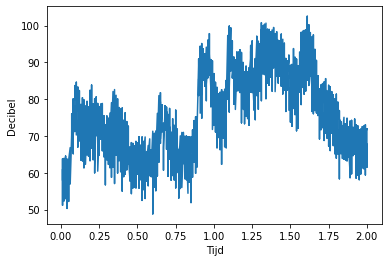

In [92]:
plt.plot(a.t,B) #Een plot van de decibel tegen de tijd.
plt.xlabel("Tijd")
plt.ylabel("Decibel")

In [ ]:
#De data wordt opgeslagen in het excel document 'Meetdata'.
a.to_excel (r'C:\Users\efrai\Documents\School\Excel\Meetdata.xlsx', index = False, header = True)
print("De data is overgezet")